# **OLD CAR PRICE PREDICTION - XGBOOST ENSEMBLE**

## R²: 0.986
## MAE: 97044.400
## MAPE: 0.127

# **DATA LOADING AND TREATMENT**

In [1]:
!pip install -q kagglehub category_encoders xgboost optuna

In [2]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("milanvaddoriya/old-car-price-prediction")

complete_path = os.path.join(path, "car_price.csv")

df = pd.read_csv(complete_path)

In [11]:
df.head()

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


In [10]:
df.shape

(5512, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           5512 non-null   int64 
 1   car_name             5512 non-null   object
 2   car_prices_in_rupee  5512 non-null   object
 3   kms_driven           5512 non-null   object
 4   fuel_type            5512 non-null   object
 5   transmission         5512 non-null   object
 6   ownership            5512 non-null   object
 7   manufacture          5512 non-null   int64 
 8   engine               5512 non-null   object
 9   Seats                5512 non-null   object
dtypes: int64(2), object(8)
memory usage: 430.8+ KB


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

## CONVERT PRICES AND CLEAR NUMBERS

In [13]:
def convert_price(x):
    try:
        x = str(x).lower().replace(',','').strip()
        if 'lakh' in x:
            return float(x.replace(' lakh','')) * 100000
        elif 'crore' in x:
            return float(x.replace(' crore','')) * 10000000
        else:
            return float(x)
    except:
        return np.nan

In [14]:
def clean_numeric(x):
    try:
        x = str(x).lower().replace(',','').replace(' kms','').replace(' cc','').replace(' seats','').strip()
        if x == '':
            return np.nan
        return float(x)
    except:
        return np.nan

In [15]:
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(convert_price)
df['kms_driven'] = df['kms_driven'].apply(clean_numeric)
df['engine'] = df['engine'].apply(clean_numeric)
df['Seats'] = df['Seats'].apply(clean_numeric)

## **CAR AGE**

In [16]:
CURRENT_YEAR = 2025
df['car_age'] = CURRENT_YEAR - df['manufacture']

## **BRAND AND MODEL**

In [17]:
df['brand'] = df['car_name'].apply(lambda x: str(x).split()[0])
df['model'] = df['car_name'].apply(lambda x: ' '.join(str(x).split()[1:3]))

## **BASIC STATISTICS**

In [18]:
print("Shape:", df.shape)
print("Columns:", df.columns)
print("\nNull values by column:")
print(df.isna().sum())

Shape: (5512, 13)
Columns: Index(['Unnamed: 0', 'car_name', 'car_prices_in_rupee', 'kms_driven',
       'fuel_type', 'transmission', 'ownership', 'manufacture', 'engine',
       'Seats', 'car_age', 'brand', 'model'],
      dtype='object')

Null values by column:
Unnamed: 0             0
car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
car_age                0
brand                  0
model                  0
dtype: int64


In [19]:
print("\nNumeric summary:")
print(df[['car_prices_in_rupee','kms_driven','engine','Seats','car_age']].describe())


Numeric summary:
       car_prices_in_rupee     kms_driven       engine        Seats  \
count         5.512000e+03    5512.000000  5512.000000  5512.000000   
mean          1.162510e+06   63211.888062  1532.299710     5.250726   
std           1.969919e+06   41844.131167   579.210876     0.720075   
min           3.500000e+04     250.000000     0.000000     2.000000   
25%           3.150000e+05   33151.750000  1197.000000     5.000000   
50%           5.500000e+05   59000.000000  1396.000000     5.000000   
75%           1.025750e+06   84265.250000  1950.000000     5.000000   
max           1.920000e+07  560000.000000  5950.000000     8.000000   

           car_age  
count  5512.000000  
mean      9.544448  
std       3.927974  
min       3.000000  
25%       7.000000  
50%       9.000000  
75%      12.000000  
max      30.000000  


## **PRICE DISTRIBUTION**

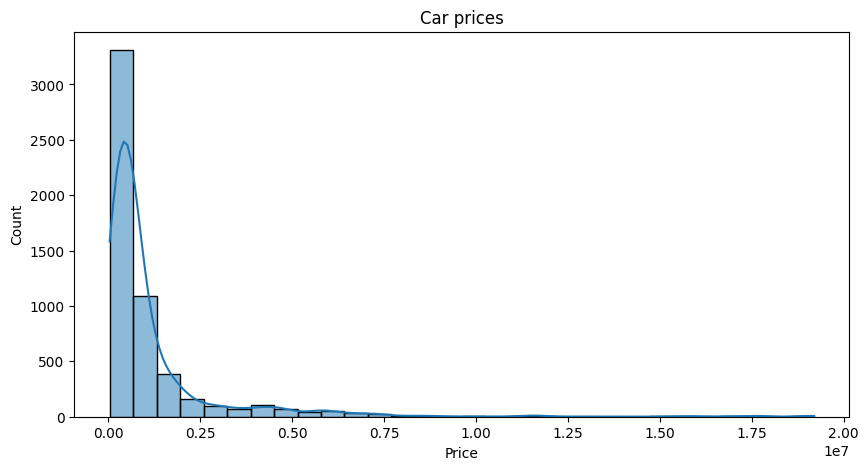

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(df['car_prices_in_rupee'], bins=30, kde=True)
plt.title("Car prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

## **KMs DRIVEN**

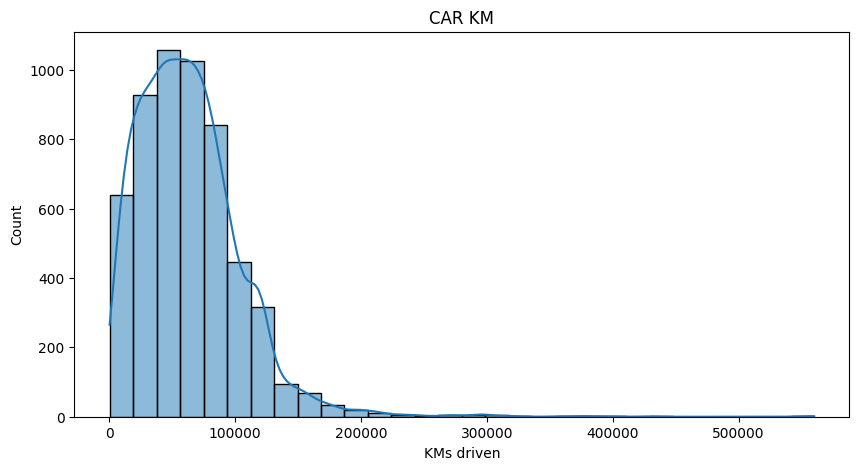

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(df['kms_driven'], bins=30, kde=True)
plt.title("CAR KM")
plt.xlabel("KMs driven")
plt.ylabel("Count")
plt.show()

## **CATEGORIES**

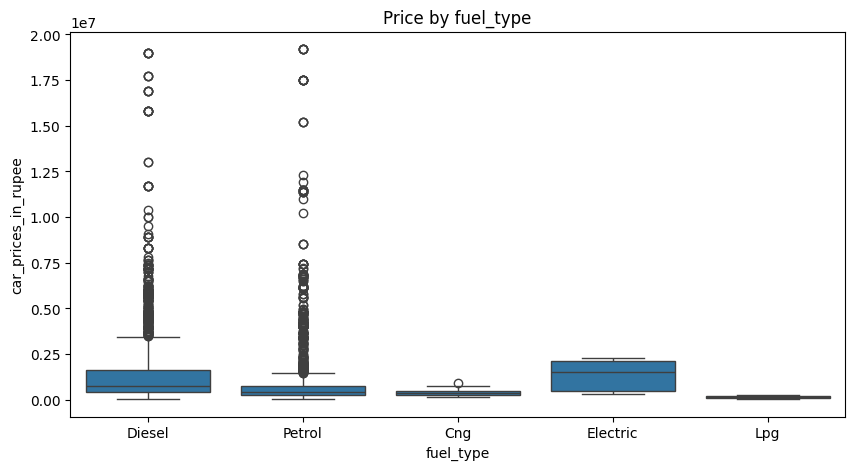

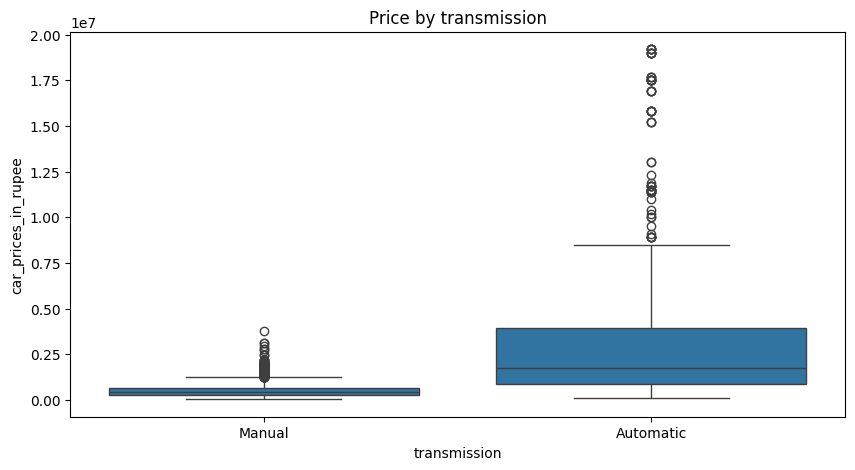

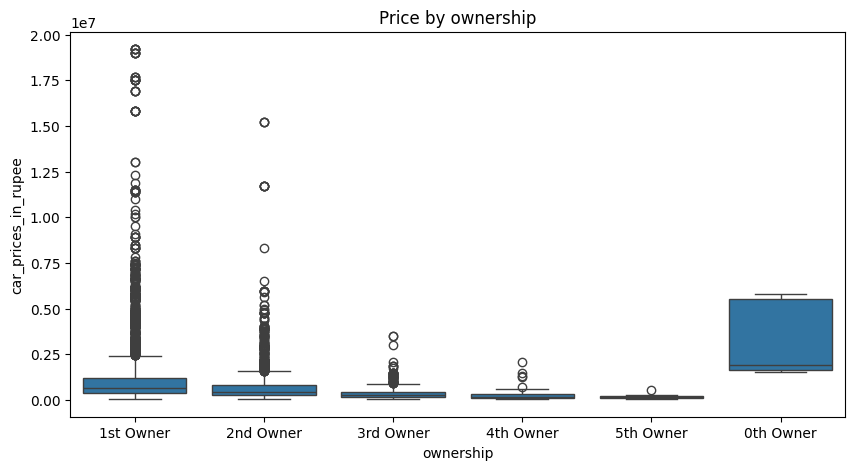

In [23]:
categorical_cols = ['fuel_type','transmission','ownership']
for col in categorical_cols:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=col, y='car_prices_in_rupee', data=df)
    plt.title(f"Price by {col}")
    plt.show()

## **BRAND AND MODEL**

In [24]:
brand_stats = df.groupby('brand')['car_prices_in_rupee'].agg(['count','mean','median','std','min','max']).sort_values(by='mean', ascending=False)
print("\nStatistics by brand:")
print(brand_stats.head(20))


Statistics by brand:
               count          mean     median           std        min  \
brand                                                                    
Porsche           10  8.507100e+06  5800000.0  6.340581e+06  2200000.0   
Land              50  7.905600e+06  4875000.0  6.281326e+06  1300000.0   
Bentley            1  6.890000e+06  6890000.0           NaN  6890000.0   
Maserati           5  6.600000e+06  6600000.0  0.000000e+00  6600000.0   
Volvo             31  4.506645e+06  5450000.0  2.090788e+06   820000.0   
Mercedes-Benz    283  4.480042e+06  4350000.0  2.932785e+06   350000.0   
Lexus             10  4.400000e+06  4200000.0  3.655285e+05  3975000.0   
BMW              172  4.193703e+06  4000000.0  2.617079e+06   375000.0   
Jaguar            30  4.040133e+06  2980000.0  2.086546e+06  1375000.0   
Mini              14  3.190643e+06  3450000.0  9.754792e+05  1890000.0   
Audi             166  2.746169e+06  1980000.0  2.726575e+06   550000.0   
Toyota          

In [25]:
model_stats = df.groupby('model')['car_prices_in_rupee'].agg(['count','mean','median','std','min','max']).sort_values(by='mean', ascending=False)
print("\nStatistics by model:")
print(model_stats.head(20))


Statistics by model:
                 count          mean      median           std         min  \
model                                                                        
Panamera GTS         3  1.750000e+07  17500000.0  0.000000e+00  17500000.0   
RS7 4.0              4  1.750000e+07  17500000.0  0.000000e+00  17500000.0   
G G63                3  1.520000e+07  15200000.0  0.000000e+00  15200000.0   
Land Cruiser        13  1.433846e+07  15800000.0  3.761768e+06   5400000.0   
S-Class Maybach      1  1.190000e+07  11900000.0           NaN  11900000.0   
GLS 400d             5  1.170000e+07  11700000.0  0.000000e+00  11700000.0   
X7 xDrive            6  1.163333e+07  11500000.0  3.265986e+05  11500000.0   
GLE 400d             1  1.040000e+07  10400000.0           NaN  10400000.0   
Q8 55                1  1.020000e+07  10200000.0           NaN  10200000.0   
Rover Range         34  9.538588e+06   7825000.0  6.875350e+06   1300000.0   
GLE 300d             5  8.900000e+06   890

## **CORRELATION**

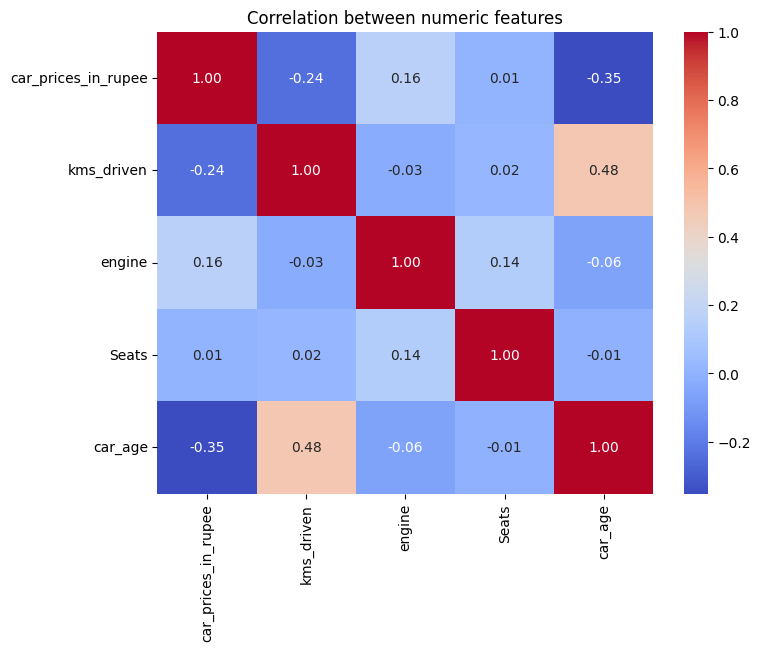

In [28]:
numeric_cols = ['car_prices_in_rupee','kms_driven','engine','Seats','car_age']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation between numeric features")
plt.show()

## **INSIGHTS**



*   **New cars have higher prices**
*   **Higher km driven decrease prices**
*   **Automatic transmissions have higher prices**
*   **Eletric cars have higher prices**
*   **KM driven concentrated between 0 and 100000**
*   **Most cars have lower prices, but price variation may generate outliers**
*   **Numeric features don't have significant autocorrelation**
*   **KM driven are concentrated between 0 and 100000**
*   **Luxury brands lead to higher prices**



# **XGBRegressor MODEL**



*   **Good for tabular data with heterogenous features (categorial and numerical)**
*   **Works well with outliers and captures non linear interactions**



## **IMPORTS**

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.cluster import KMeans
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
import optuna
import warnings

In [31]:
warnings.filterwarnings("ignore")

In [32]:
df = df.drop(columns=['Unnamed: 0','car_name','manufacture'])

## **WINSORIZATION TO MITIGATE INFLUENCE OF OUTLIERS**

In [33]:
#winsorization 1%-99%
for col in ['car_prices_in_rupee','kms_driven','engine','car_age']:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower, upper)

## **FEATURE ENGINEERING**

In [34]:
#basic interactions and ratios
df['kms_per_year'] = df['kms_driven'] / (df['car_age'] + 1)
df['engine_age_ratio'] = df['engine'] / (df['car_age'] + 1)
df['seats_engine'] = df['Seats'] * df['engine']
df['engine_kms_ratio'] = df['engine'] / (df['kms_driven'] + 1)

#math transformation
df['kms_per_year_sqrt'] = np.sqrt(df['kms_per_year'])
df['engine_age_ratio_sq'] = np.power(df['engine_age_ratio'], 2)
df['Seats_log'] = np.log1p(df['Seats'])

#KMeans custerization (3 simple clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
numeric_feats = df[['kms_driven','engine','car_age','Seats']]
df['car_segment'] = kmeans.fit_predict(numeric_feats)

#aggregated statistics for brand and model
agg = df.groupby(['brand','model'])['car_prices_in_rupee'].agg(['mean','median','std','count','max','min']).reset_index()
agg.columns = ['brand','model','brand_model_mean','brand_model_median','brand_model_std','brand_model_count','brand_model_max','brand_model_min']
df = df.merge(agg, on=['brand','model'], how='left')

#target log transformation
df['car_prices_in_rupee_log'] = np.log1p(df['car_prices_in_rupee'])

## **ENCODING**

In [35]:
#enconding
df['brand_model'] = df['brand'] + '_' + df['model']
te = TargetEncoder(cols=['brand_model'])
df['brand_model_enc'] = te.fit_transform(df['brand_model'], df['car_prices_in_rupee_log'])
df = df.drop(columns=['brand','model','brand_model'])

#one-hot encoding for dummies
df = pd.get_dummies(df, columns=['fuel_type','transmission','ownership'], drop_first=True)

## **SPLIT**

In [36]:
X = df.drop(columns=['car_prices_in_rupee','car_prices_in_rupee_log'])
y = df['car_prices_in_rupee_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **HYPERPARAMETER TUNING WITH OPTUNA**

In [ ]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 42
    }
    model = XGBRegressor(**param)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    return scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40, show_progress_bar=True)

best_params = study.best_params
print("Melhores parâmetros XGBoost:", best_params)

## **XGBOOSTS ENSEMBLE**

In [38]:
n_models = 5
preds_ensemble_log = []

for seed in range(n_models):
    model = XGBRegressor(**best_params, random_state=seed)
    model.fit(X_train, y_train)
    preds_ensemble_log.append(model.predict(X_test))

#prediction means
y_pred_ensemble_log = np.mean(preds_ensemble_log, axis=0)
y_pred_ensemble = np.expm1(y_pred_ensemble_log)
y_test_real = np.expm1(y_test)

## **MODEL EVALUATION**

In [39]:
print("Ensemble MAE:", mean_absolute_error(y_test_real, y_pred_ensemble))
print("Ensemble R²:", r2_score(y_test_real, y_pred_ensemble))
print("Ensemble MAPE:", mean_absolute_percentage_error(y_test_real, y_pred_ensemble))

Ensemble MAE: 96182.32484842617
Ensemble R²: 0.9868383869146873
Ensemble MAPE: 0.1268315685615617


## **CONFIDENCE INTERVALS 95%**

In [45]:
std_preds_log = np.std(preds_ensemble_log, axis=0)
lower_bound = np.expm1(y_pred_ensemble_log - 1.96*std_preds_log)
upper_bound = np.expm1(y_pred_ensemble_log + 1.96*std_preds_log)

intervals_df = pd.DataFrame({
    'Predicted_Price': y_pred_ensemble,
    'Lower_95CI': lower_bound,
    'Upper_95CI': upper_bound,
    'Actual_Price': y_test_real.values,
    'Diiference': y_test_real.values - y_pred_ensemble
})
intervals_df.head(10)

,Predicted_Price,Lower_95CI,Upper_95CI,Actual_Price,Diiference
0,631441.12500,625927.00000,637003.81250,631000.0,-441.12500
1,307420.43750,299474.81250,315576.90625,308000.0,579.56250
2,448261.81250,441911.43750,454703.43750,465000.0,16738.18750
3,336766.81250,331357.00000,342264.93750,260000.0,-76766.81250
4,646282.18750,637305.18750,655385.62500,725000.0,78717.81250
5,192652.71875,190576.09375,194751.96875,175000.0,-17652.71875
6,363752.81250,355232.28125,372477.75000,375000.0,11247.18750
7,359262.37500,353294.37500,365331.18750,417000.0,57737.62500
8,307618.12500,302202.09375,313131.21875,275000.0,-32618.12500
9,865391.56250,851308.87500,879707.18750,945000.0,79608.43750


## **FEATURE IMPORTANCE**

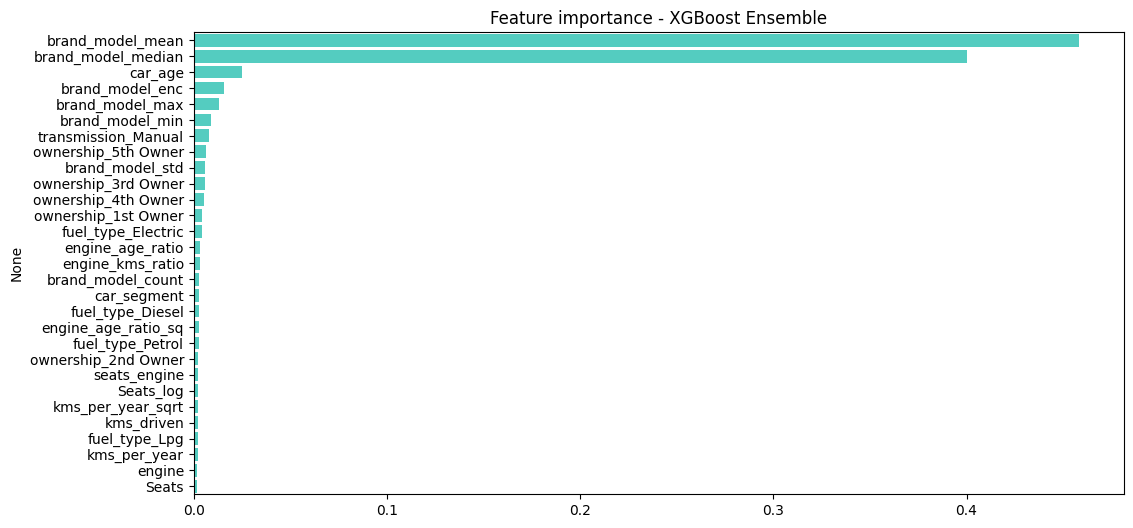

In [41]:
importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=importance.values, y=importance.index, color='turquoise')
plt.title("Feature importance - XGBoost Ensemble")
plt.show()